In [1]:

# load libraries
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}
quiet_library(tidyverse)
quiet_library(Seurat)
quiet_library(ggplot2)
quiet_library(Matrix)
quiet_library(dplyr)
quiet_library(viridis)
quiet_library(harmony)
quiet_library(future)
quiet_library(future.apply)
quiet_library(SingleCellExperiment)
quiet_library(SeuratDisk)
quiet_library(ggpubr)
quiet_library(knitr)
quiet_library(plotly)
quiet_library(lme4)
quiet_library(ggpubr)
quiet_library(qvalue)
quiet_library(ggrepel)

Warning message:
“package ‘qvalue’ was built under R version 4.3.2”


In [2]:
# Check number of cores
future::availableCores()
# Set up parallel processing to run when using 'future' functions 
future::plan(strategy = "multicore", workers = future::availableCores()-5)  
options(future.globals.maxSize = 1000 * 1024^3)
# to turn off parallel processing run line below
# future::plan(strategy = "sequential")

system 
    64

In [3]:
# define the color palette to be used
npg_color <- c("#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", 
               "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF")
nejm_color <- c("#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF", "#7876B1FF", "#6F99ADFF", "#FFDC91FF", "#EE4C97FF")
jama_color <- c("#374E55FF", "#DF8F44FF", "#00A1D5FF", "#B24745FF", "#79AF97FF", "#6A6599FF", "#80796BFF")
jco_color <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF", "#8F7700FF")
cluster_colors <- c("#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72", "#B17BA6", "#FF7F00", "#FDB462", "#E7298A", 
    "#E78AC3", "#33A02C", "#B2DF8A", "#55A1B1", "#8DD3C7", "#A6761D", "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999", 
    "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000", "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00")
coolors_clrs<-c("#EFB0A1","#009FF5","#1A5E9B","#42E2B8","#4ECDC4","#89B6A5","#F1D26A","#D5B0AC","#EDABB1","#02504D","#AA9674","#E64B35FF","#4DBBD5FF","#00A087FF")

cluster_colors_ext <- colorRampPalette(cluster_colors)(36)
options(repr.plot.width =5, repr.plot.height =5)

In [4]:
fig_path="/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_files/Certpro_figures/Plots_for_manuscript/"

In [5]:
# calculate the q_value
calQvalue <- function(df) {
  mutate(df, q_values = qvalue::qvalue(p.value)$qvalues)
}

In [6]:

# define a function to plot linear mixed model fit for individual gene
plotFitLmer<- function(fit, gene){
    # extract the fit data
    fit_data <- fit[[gene]]@frame 
    predicted_values<- modelr::data_grid(fit_data, age_conv, bmi_conv,
                                         days_to_conversion, subject.subjectGuid) %>% 
                       modelr::add_predictions(fit[[gene]])
    # plot the residue
    df_model <- broom.mixed::augment(fit[[gene]])
    df_model[".stdresid"] <- resid(fit[[gene]], type = "pearson")

    # plot the predicted regression line
    p2<-fit_data %>%  ggplot(aes(x=days_to_conversion, y=count)) +
        geom_line(aes(color=subject.subjectGuid)) + geom_point(aes(color=subject.subjectGuid))+ 
           stat_smooth(data=predicted_values, method = 'lm', se = FALSE,
                   aes(x=days_to_conversion, y=pred, color = subject.subjectGuid))+
        ggtitle(gene) + scale_color_subj() + theme_bw() + 
        ylab('Normalized count')
    return(p2)
}

#' Plot a frequency line plot with prediction
#'
#' This function takes a frequency table, a model fit, and various parameters to create a line plot with prediction.
#'
#' @param frequency_table A data frame containing the frequency data.
#' @param model_fit The model fit object.
#' @param palette A vector of colors for the line plot.
#' @param fig_path The file path to save the plot. Default is NULL.
#' @param fig_name The name of the figure Default is NULL.
#' @param x_var The variable for the x-axis. Default is "days_to_conversion".
#' @param y_var The variable for the y-axis. Default is "clr".
#' @param color_var The variable for coloring the lines. Default is "subject.subjectGuid".
#' @param shape_var The variable for shaping the points. Default is "sex".
#' @param title The title of the plot. Default is "Cluster 9".
#' @param x_label The label for the x-axis. Default is "Days to Conversion".
#' @param y_label The label for the y-axis. Default is "CLR".
#' @param annotation_text The text for the annotation. Default is "p=0.055".
#' @param annotation_x The x-coordinate for the annotation. Default is -600.
#' @param annotation_y The y-coordinate for the annotation. Default is 1.
#' @param annotation_color The color for the annotation. Default is "red".
#'
#' @return The plot object.
#'
#' @examples
#' # Example usage of PlotFreqLinePlot function
#' PlotFreqLinePlot(frequency_table, model_fit, palette, fig_path = "path/to/save", fig_name = "fig_name",
#'                  x_var = "days_to_conversion", y_var = "clr", color_var = "subject.subjectGuid",
#'                  shape_var = "sex", title = "Cluster 9", x_label = "Days to Conversion", 
#'                  y_label = "CLR", annotation_text = "p=0.055", annotation_x = -600, 
#'                  annotation_y = 1, annotation_color = "red")
#'
#' @export
PlotPredLinePlot <- function(model_fit,  fig_path = NULL, fig_name = NULL,
                             x_var = "days_to_conversion", y_var = "clr", color_var = "subject.subjectGuid",
                             shape_var = "sex", title = "Cluster 9", x_label = "Days to Conversion", 
                             y_label = "CLR") {
    require(ggplot2)
    require(ggeffects)
    
    # Extract the prediction data frame
    
    pred.mm <- ggpredict(model_fit, terms = c(x_var))  # Adjusted to use x_var
    fit_data <- model_fit@frame 
    # plot
    p1 <- fit_data %>%
        ggplot() +
        geom_line(aes(x = .data[[x_var]], y = .data[[y_var]], color = .data[[color_var]]), size = 1) + 
        geom_point(aes(x = .data[[x_var]], y = .data[[y_var]])) + 
        geom_line(data=pred.mm, aes(x = x, y = predicted), color="#8F7700FF", size = 2) +          
        geom_ribbon(data=pred.mm, aes(x = x, ymin = predicted - 2 * std.error, ymax = predicted +2 * std.error), 
                    fill = "#8F7700FF", alpha = 0.3) + 

        labs(title = title) + xlab(x_label) +  ylab(y_label)+
        #scale_color_subj() +
        ggpubr::theme_pubr() +
        scale_shape_manual(values = c(1, 2))  + guides(color = FALSE)
    
    # Code to save the plot if fig_path and proj_name are provided
        # Check if fig_path and proj_name are provided and not empty
    if (!missing(fig_path) && !missing(fig_name) && nzchar(fig_path) && nzchar(fig_name)) {
        # Construct the full file path with the project name and desired file extension
        file_name <- paste0(fig_path, "/", fig_name)
        # Use ggsave to save the plot
        ggsave(file_name, plot = p1, width = 8, height = 8, dpi = 300)
    }
    return(p1)
}


In [7]:
# Function to generate a volcano plot with customized settings
# 
# This function creates a volcano plot from gene expression data, highlighting significant genes 
# with specific colors based on their log fold change and adjusted p-values. It includes options 
# for customizing plot labels, axis limits, and saving the plot to a specified file path.
#
# Parameters:
# - data: The main data frame containing the gene expression data.
# - logfc_column: The name of the column in 'data' representing log fold change.
# - pval_column: The name of the column in 'data' representing p-values.
# - padj_column: The name of the column in 'data' representing adjusted p-values.
# - gene_column: The name of the column in 'data' representing gene names.
# - filtered_genes: A data frame containing a subset of genes to be highlighted on the plot.
# - title: The title of the volcano plot.
# - x_label: The label for the x-axis.
# - y_label: The label for the y-axis.
# - x_limits: A numeric vector of length 2 specifying the range of the x-axis (optional).
# - y_limits: A numeric vector of length 2 specifying the range of the y-axis (optional).
# - file_path: The directory path where the plot should be saved (optional).
# - file_name: The name of the file to save the plot as (optional).
# - max_overlaps: The maximum number of overlapping text labels allowed by geom_text_repel (default is 20).

plot_custom_volcano <- function(data, logfc_column, pval_column, padj_column, gene_column, filtered_genes, 
                         title, x_label, y_label, x_limits = NULL, y_limits = NULL, file_path = NULL, file_name = NULL,max_overlaps) {
  # Custom color mapping based on log fold change and padj significance
  data$sig_color <- ifelse(data[[padj_column]] > 0.1, 'black',
                           ifelse(data[[logfc_column]] < 0 & data[[padj_column]] < 0.1, '#F59F00',
                                  ifelse(data[[logfc_column]] > 0 & data[[padj_column]] < 0.1, '#840032', 'black')))
  # Print total number of genes
  total_genes <- nrow(data)

    p <- ggplot(data, aes_string(x = logfc_column, y = paste0("-log10(", padj_column, ")"), color = "sig_color")) +
    geom_point(size = 1.5) +  # Adjust size and transparency
    geom_hline(yintercept = 1, linetype = "dashed", color = "black") +
    geom_vline(xintercept = 0, linetype = "dashed") +  # Add significance threshold line
    labs(x = x_label, y = y_label, title = title) +  # Labels and title
    theme_minimal() +  # Minimal theme
    geom_point(data = filtered_genes, aes_string(x = logfc_column, y = paste0("-log10(", padj_column, ")")), 
               color = "005E7A", size = 1.5) +  # Overlay the filtered genes
    geom_text_repel(data = filtered_genes, aes_string(x = logfc_column, y = paste0("-log10(", padj_column, ")"), label = gene_column),
                    hjust = -0.4, vjust = -0.7, size = 5,color = "black", max.overlaps = max_overlaps) + # Add gene labels
    scale_color_manual(values = c("black" = "black", "#F59F00" = "#F59F00", "#840032" = "#840032")) + 
    # Manual color scale
    theme_light()+
    theme(legend.position = "none")+  # Remove the legend
     annotate("text", x = Inf, y = -Inf, label = paste("Total genes:", total_genes), hjust = 1, vjust = -1,
             color = "black", size = 5)
      
  
  # Set x and y axis limits if specified
  if (!is.null(x_limits)) {
    p <- p + xlim(x_limits)
  }
  if (!is.null(y_limits)) {
    p <- p + ylim(y_limits)
  }
  
  # Save the plot if file_path and file_name 
  if (!is.null(file_path) & !is.null(file_name)) {
    full_path <- file.path(file_path, file_name)
    ggsave(full_path, plot = p, width = 5, height = 5)
  }
  
  print(p)
}
# usage
# plot_custom_volcano(data = deg_a3, logfc_column = "logfc_by_year", pval_column = "p.value", 
#              padj_column = "padj", gene_column = "gene", filtered_genes = filtered_df_gene, 
#              title = "Core Naive CD4 T cells", x_label = "log2FC by year", y_label = "-log10(padj)",
#              x_limits = c(-0.8,0.8), y_limits = c(0.5, 2), max_overlaps = 35,
#              file_path = fig_path, file_name = "Fig_6A_CD4_naive_volcano_plot.pdf")

## Figure S8A

In [8]:
## reading the lmer output
cd4_lmr=read.csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/input_files/Zi_aim3_deg_models/model_output/ALTRA_AIM3_certpro_scRNA_Pseudobulk_AIFI_l3__Core naive CD4 T cell_lme4_vst_models_results.csv")
cd4_lmr%>%dim
cd4_lmr%>%head(3)

[1] 29700    10

,effect,group,term,estimate,std.error,statistic,df,p.value,gene,celltype
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,fixed,NA,(Intercept),9.137827482,0.533359349,17.1325908,9.905556,1.092232e-08,A1BG,Core naive CD4 T cell
2,fixed,NA,age_conv,-0.002336263,0.007296238,-0.3202010,9.867989,7.554929e-01,A1BG,Core naive CD4 T cell
3,fixed,NA,bmi_conv,-0.011343048,0.017334739,-0.6543536,9.856688,5.278561e-01,A1BG,Core naive CD4 T cell


In [9]:
# filter only for days to conversion
cd4_lmr=cd4_lmr%>%filter(term=="days_to_conversion")
cd4_lmr%>%dim
cd4_lmr%>%head(3)

[1] 4950   10

,effect,group,term,estimate,std.error,statistic,df,p.value,gene,celltype
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,fixed,NA,days_to_conversion,-3.377828e-04,0.0001303560,-2.59123334,38.52058,0.0134362,A1BG,Core naive CD4 T cell
2,fixed,NA,days_to_conversion,5.778606e-06,0.0001718983,0.03361642,46.00000,0.9733285,AAK1,Core naive CD4 T cell
3,fixed,NA,days_to_conversion,-1.619124e-04,0.0001019456,-1.58822357,46.00000,0.1190865,AAMP,Core naive CD4 T cell


In [10]:
# calculate Qvalue
cd4_lmr=calQvalue(cd4_lmr)

In [11]:
cd4_lmr%>%head(3)

,effect,group,term,estimate,std.error,statistic,df,p.value,gene,celltype,q_values
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,fixed,NA,days_to_conversion,-3.377828e-04,0.0001303560,-2.59123334,38.52058,0.0134362,A1BG,Core naive CD4 T cell,0.03888719
2,fixed,NA,days_to_conversion,5.778606e-06,0.0001718983,0.03361642,46.00000,0.9733285,AAK1,Core naive CD4 T cell,0.32250224
3,fixed,NA,days_to_conversion,-1.619124e-04,0.0001019456,-1.58822357,46.00000,0.1190865,AAMP,Core naive CD4 T cell,0.08462192


In [12]:
# estimate is Log2FC
cd4_lmr_filt <- cd4_lmr %>% 
    dplyr::filter(p.value<0.05 & q_values<0.1) 
cd4_lmr_filt%>%head(3)
cd4_lmr_filt%>%dim

,effect,group,term,estimate,std.error,statistic,df,p.value,gene,celltype,q_values
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,fixed,NA,days_to_conversion,-0.0003377828,1.303560e-04,-2.591233,38.52058,0.01343620,A1BG,Core naive CD4 T cell,0.03888719
2,fixed,NA,days_to_conversion,0.0004133608,1.542928e-04,2.679067,45.48538,0.01024110,ABCD2,Core naive CD4 T cell,0.03716149
3,fixed,NA,days_to_conversion,0.0001118393,5.009809e-05,2.232406,45.77825,0.03052221,ABCE1,Core naive CD4 T cell,0.04723671


[1] 1430   11

In [13]:
cd4_lmr_filt%>%filter(gene %in% c('STAT5B', 'STAT2', 'STIM2', 'AKT3', 'CD28', 'FOSB', 'PTPN4'))

effect,group,term,estimate,std.error,statistic,df,p.value,gene,celltype,q_values
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
fixed,NA,days_to_conversion,0.0005263800,1.967998e-04,2.674697,43.48119,0.010498803,AKT3,Core naive CD4 T cell,0.03720433
fixed,NA,days_to_conversion,0.0003369934,1.496021e-04,2.252598,42.94973,0.029449061,CD28,Core naive CD4 T cell,0.04628044
fixed,NA,days_to_conversion,0.0017216025,6.395260e-04,2.691998,43.90302,0.010014087,FOSB,Core naive CD4 T cell,0.03709047
fixed,NA,days_to_conversion,0.0003035708,7.987098e-05,3.800765,45.39132,0.000427574,PTPN4,Core naive CD4 T cell,0.02093277
fixed,NA,days_to_conversion,0.0002869178,1.089561e-04,2.633334,45.99397,0.011476963,STAT2,Core naive CD4 T cell,0.03820139
fixed,NA,days_to_conversion,0.0003203948,1.133097e-04,2.827603,44.19388,0.007021486,STAT5B,Core naive CD4 T cell,0.03567915
fixed,NA,days_to_conversion,0.0002696015,8.224771e-05,3.277920,42.77197,0.002081340,STIM2,Core naive CD4 T cell,0.02653349


In [14]:
cd4_naive=readRDS("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/input_files/Zi_aim3_deg_models/model_output/ALTRA_AIM3_certpro_scRNA_Pseudobulk_AIFI_l3__Core naive CD4 T cell_lme4_vst_models.rds")

In [17]:
genes_plot = c('STAT5B', 'STAT2', 'STIM2', 'AKT3', 'CD28', 'FOSB', 'PTPN4')

p_list <- lapply(genes_plot, function(gene_plot){
    p <- PlotPredLinePlot(cd4_naive[[gene_plot]], 
                 y_var = "count", shape_var=NULL, 
                  title =gene_plot, y_label = "Normalized expression",fig)
    return(p)
})
   

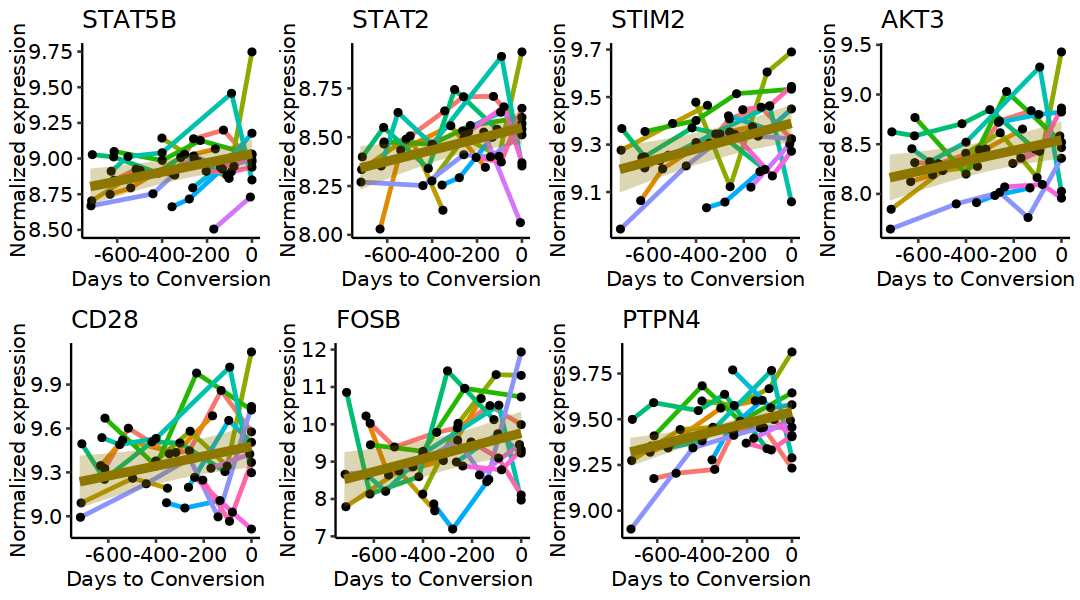

In [18]:
options(repr.plot.width =9, repr.plot.height =5)
cd4_plots=cowplot::plot_grid(plotlist = p_list,ncol=4)
cd4_plots

In [20]:
ggsave('/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_files/Certpro_figures/Plots_for_manuscript/Fig_S8A.pdf',pl=cd4_plots, width = 9, height = 5)

# Figure S8B

In [21]:
## reading the lmer output
cd8_lmr=read.csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/input_files/Zi_aim3_deg_models/model_output/ALTRA_AIM3_certpro_scRNA_Pseudobulk_AIFI_l3__Core naive CD8 T cell_lme4_vst_models_results.csv")
cd8_lmr%>%dim
cd8_lmr%>%head(3)

[1] 33732    10

,effect,group,term,estimate,std.error,statistic,df,p.value,gene,celltype
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,fixed,NA,(Intercept),8.551244834,0.317413931,26.9403577,8.539862,1.464458e-09,A1BG,Core naive CD8 T cell
2,fixed,NA,age_conv,-0.005282494,0.004334116,-1.2188169,8.474006,2.557543e-01,A1BG,Core naive CD8 T cell
3,fixed,NA,bmi_conv,-0.005742525,0.010284532,-0.5583652,8.394264,5.911738e-01,A1BG,Core naive CD8 T cell


In [22]:
# filter only for days to conversion
cd8_lmr=cd8_lmr%>%filter(term=="days_to_conversion")
cd8_lmr%>%dim
cd8_lmr%>%head(3)

[1] 5622   10

,effect,group,term,estimate,std.error,statistic,df,p.value,gene,celltype
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,fixed,NA,days_to_conversion,-0.0003365060,0.0001393532,-2.4147715,42.52827,0.020121284,A1BG,Core naive CD8 T cell
2,fixed,NA,days_to_conversion,-0.0000390451,0.0001720038,-0.2270014,46.00000,0.821428504,AAK1,Core naive CD8 T cell
3,fixed,NA,days_to_conversion,-0.0003630197,0.0001186396,-3.0598518,44.53345,0.003743043,AAMP,Core naive CD8 T cell


In [23]:
# calculate Qvalue
cd8_lmr=calQvalue(cd8_lmr)
cd8_lmr%>%head(3)

,effect,group,term,estimate,std.error,statistic,df,p.value,gene,celltype,q_values
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,fixed,NA,days_to_conversion,-0.0003365060,0.0001393532,-2.4147715,42.52827,0.020121284,A1BG,Core naive CD8 T cell,0.12488167
2,fixed,NA,days_to_conversion,-0.0000390451,0.0001720038,-0.2270014,46.00000,0.821428504,AAK1,Core naive CD8 T cell,0.46523124
3,fixed,NA,days_to_conversion,-0.0003630197,0.0001186396,-3.0598518,44.53345,0.003743043,AAMP,Core naive CD8 T cell,0.07717608


In [24]:

cd8_lmr_filt <- cd8_lmr %>% 
    dplyr::filter(p.value<0.05 & q_values<0.1) 
cd8_lmr_filt%>%head(3)
cd8_lmr_filt%>%dim

,effect,group,term,estimate,std.error,statistic,df,p.value,gene,celltype,q_values
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,fixed,NA,days_to_conversion,-0.0003630197,0.0001186396,-3.059852,44.53345,0.003743043,AAMP,Core naive CD8 T cell,0.07717608
2,fixed,NA,days_to_conversion,0.0004110994,0.0001410407,2.914758,45.77300,0.005492645,AC005261.1,Core naive CD8 T cell,0.08206516
3,fixed,NA,days_to_conversion,-0.0005279027,0.0001719759,-3.069632,38.49284,0.003917053,AC013264.1,Core naive CD8 T cell,0.07717608


[1] 305  11

In [25]:
cd8_lmr_filt%>%filter(gene %in% c('STAT5B', 'STAT2', 'STIM2', 'AKT3', 'CD28', 'FOSB', 'PTPN4'))

effect,group,term,estimate,std.error,statistic,df,p.value,gene,celltype,q_values
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
fixed,NA,days_to_conversion,0.0005909115,1.967237e-04,3.003764,45.90047,4.307739e-03,AKT3,Core naive CD8 T cell,0.07972531
fixed,NA,days_to_conversion,0.0005062691,1.026667e-04,4.931192,45.99314,1.107278e-05,PTPN4,Core naive CD8 T cell,0.01058800
fixed,NA,days_to_conversion,0.0003250590,1.062199e-04,3.060247,45.52418,3.701255e-03,STAT5B,Core naive CD8 T cell,0.07714363
fixed,NA,days_to_conversion,0.0003511995,9.503513e-05,3.695470,45.46070,5.879985e-04,STIM2,Core naive CD8 T cell,0.05525159


In [26]:
cd8_naive=readRDS("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/input_files/Zi_aim3_deg_models/model_output/ALTRA_AIM3_certpro_scRNA_Pseudobulk_AIFI_l3__Core naive CD8 T cell_lme4_vst_models.rds")

In [28]:
genes_plot = c('STAT5B','STIM2', 'AKT3','PTPN4')

p_list_cd8 <- lapply(genes_plot, function(gene_plot){
    p <- PlotPredLinePlot(cd8_naive[[gene_plot]], 
                 y_var = "count", shape_var=NULL, 
                  title =gene_plot, y_label = "Normalized expression",fig)
    return(p)
})
   

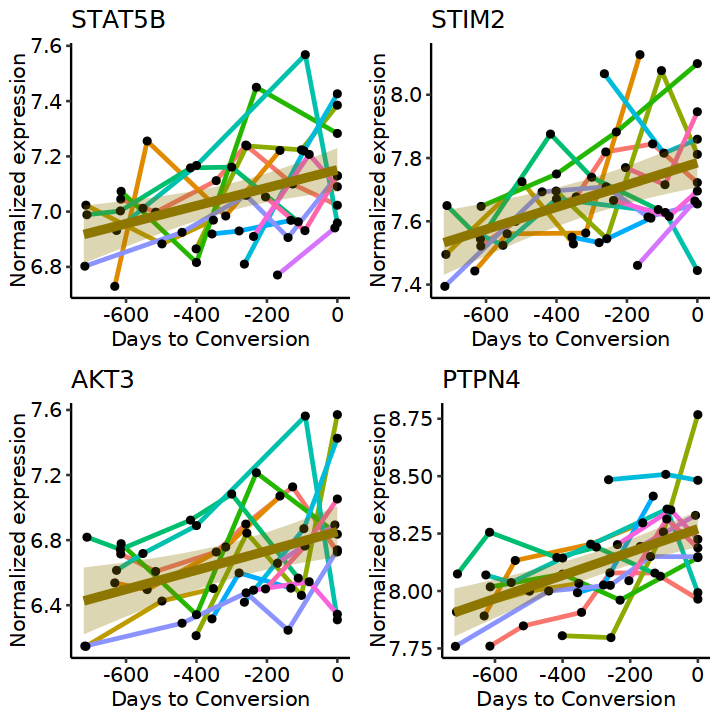

In [29]:
options(repr.plot.width =6, repr.plot.height =6)
cd8_plots=cowplot::plot_grid(plotlist = p_list_cd8)
cd8_plots

In [30]:
ggsave('/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_files/Certpro_figures/Plots_for_manuscript/Fig_S8B.pdf',pl=cd8_plots, width = 6, height = 6)

# Figure S8E

In [32]:
abt_deg=read.csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_notebooks/files/input_files/abatacept/ALTRA_AIM3_scRNA_validation_responder_pre_post_degs.csv")
abt_deg%>%dim
abt_deg%>%head(3)

[1] 13608     7

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,q_values
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TSPAN6,18.36329,-0.04054009,0.4435564,-0.09139784,0.9271765,0.6894360
2,DPM1,498.47598,-0.14877090,0.1898690,-0.78354501,0.4333071,0.5231215
3,SCYL3,454.06455,-0.09370180,0.1282288,-0.73073902,0.4649386,0.5368994


In [33]:

abt_deg<- abt_deg %>%
  mutate(logfc_by_year= log2FoldChange * 365)

abt_deg%>%dim
abt_deg%>%head(3)

[1] 13608     8

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,q_values,logfc_by_year
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TSPAN6,18.36329,-0.04054009,0.4435564,-0.09139784,0.9271765,0.6894360,-14.79713
2,DPM1,498.47598,-0.14877090,0.1898690,-0.78354501,0.4333071,0.5231215,-54.30138
3,SCYL3,454.06455,-0.09370180,0.1282288,-0.73073902,0.4649386,0.5368994,-34.20116


In [34]:
filtered_df=abt_deg %>% 
    dplyr::filter(q_values<0.1)%>%arrange(q_values)
filtered_df%>%head(3)
filtered_df%>%dim

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,q_values,logfc_by_year
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,EEF2,6952.00020,1.252571,0.1395632,8.974941,2.835033e-19,2.722390e-15,457.1885
2,PRAF2,194.08018,1.801119,0.2344268,7.683079,1.553102e-14,7.456970e-11,657.4086
3,CLIC3,50.67315,3.075168,0.4147460,7.414582,1.220088e-13,3.905371e-10,1122.4364


[1] 965   8

In [35]:
filtered_df=filtered_df[1:30,]
filtered_df

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,q_values,logfc_by_year
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,EEF2,6952.00020,1.2525712,0.1395632,8.974941,2.835033e-19,2.722390e-15,457.1885
2,PRAF2,194.08018,1.8011195,0.2344268,7.683079,1.553102e-14,7.456970e-11,657.4086
3,CLIC3,50.67315,3.0751681,0.4147460,7.414582,1.220088e-13,3.905371e-10,1122.4364
4,SQSTM1,1329.60006,1.3168178,0.1838929,7.160788,8.021470e-13,1.925690e-09,480.6385
5,PFKL,194.63331,1.2004577,0.1789514,6.708289,1.969194e-11,3.781907e-08,438.1671
6,PTPRCAP,466.60068,1.1370015,0.1785860,6.366689,1.931522e-10,3.091297e-07,415.0056
7,CYBA,405.35347,1.7318728,0.2759109,6.276928,3.453286e-10,3.929169e-07,632.1336
8,CRY2,183.01056,1.0278227,0.1642077,6.259284,3.867496e-10,3.929169e-07,375.1553
9,PRSS23,481.93612,1.3893919,0.2218286,6.263358,3.767748e-10,3.929169e-07,507.1280


In [36]:
abt_deg%>%dim

[1] 13608     8

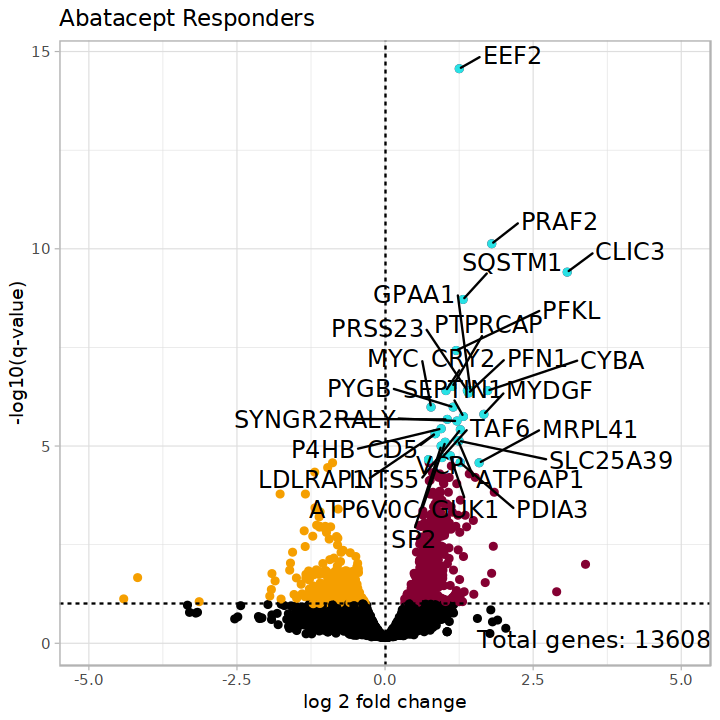

In [38]:
plot_custom_volcano(data = abt_deg, logfc_column = "log2FoldChange", pval_column = "p.value", 
             padj_column = "q_values", gene_column = "gene", filtered_genes = filtered_df, 
             title = "Abatacept Responders", x_label = "log 2 fold change", y_label = "-log10(q-value)",
             x_limits = c(-5,5), 
                   # y_limits = c(0, 20), 
                    max_overlaps = 35,
             file_path = fig_path, file_name = "Fig_S8E.pdf"
                   )

# Figure S8F

In [39]:
abt_non_deg=read.csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_notebooks/files/input_files/abatacept/ALTRA_AIM3_scRNA_validation_nonresponder_pre_post_degs.csv")
abt_non_deg%>%dim
abt_non_deg%>%head(3)

[1] 13275     7

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,q_values
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,DPM1,379.14259,-0.05712159,0.1720638,-0.3319792,0.7399050,0.9552337
2,SCYL3,343.65831,0.02574844,0.1391630,0.1850236,0.8532105,0.9655959
3,C1orf112,71.51417,-0.04306472,0.2046950,-0.2103848,0.8333674,0.9647510


In [40]:
abt_non_deg<- abt_non_deg %>%
  mutate(logfc_by_year= log2FoldChange * 365)

abt_non_deg%>%dim
abt_non_deg%>%head(3)

[1] 13275     8

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,q_values,logfc_by_year
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,DPM1,379.14259,-0.05712159,0.1720638,-0.3319792,0.7399050,0.9552337,-20.849379
2,SCYL3,343.65831,0.02574844,0.1391630,0.1850236,0.8532105,0.9655959,9.398182
3,C1orf112,71.51417,-0.04306472,0.2046950,-0.2103848,0.8333674,0.9647510,-15.718622


In [41]:
filtered_non_df=abt_non_deg %>% 
    dplyr::filter(q_values<0.1)%>%arrange(q_values)
filtered_non_df%>%head(3)
filtered_non_df%>%dim

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,q_values,logfc_by_year
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TDRD9,129.29138,-0.8628368,0.1762981,-4.894193,9.871009e-07,0.007616922,-314.9354
2,PCLAF,80.88858,-1.0818436,0.2226591,-4.858744,1.181325e-06,0.007616922,-394.8729
3,CREG1,221.21100,-0.5992515,0.1259881,-4.756413,1.970634e-06,0.008470805,-218.7268


[1] 25  8

In [42]:
filtered_non_df=filtered_non_df[1:25,]
filtered_non_df

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,q_values,logfc_by_year
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TDRD9,129.29138,-0.8628368,0.17629809,-4.894193,9.871009e-07,0.007616922,-314.9354
2,PCLAF,80.88858,-1.0818436,0.22265909,-4.858744,1.181325e-06,0.007616922,-394.8729
3,CREG1,221.21100,-0.5992515,0.12598811,-4.756413,1.970634e-06,0.008470805,-218.7268
4,METTL7B,75.44486,-1.6168274,0.36137586,-4.474088,7.673814e-06,0.024739520,-590.1420
5,HMGB3,85.42244,-0.7751012,0.17705858,-4.377654,1.199637e-05,0.028174825,-282.9119
6,SIGLEC17P,319.32190,0.4528297,0.10390110,4.358276,1.310909e-05,0.028174825,165.2828
7,NUP42,538.49685,-0.2927606,0.06894644,-4.246202,2.174242e-05,0.040054359,-106.8576
8,SERPINB10,193.49473,-0.9163811,0.21854615,-4.193078,2.751943e-05,0.044359787,-334.4791
9,METTL9,529.91879,-0.4244219,0.10230767,-4.148485,3.346822e-05,0.047954581,-154.9140


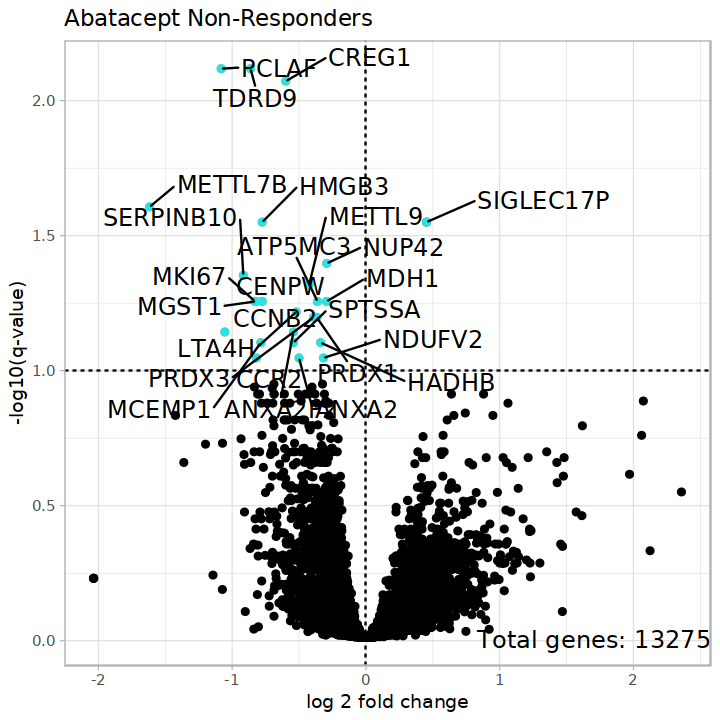

In [43]:
plot_custom_volcano(data = abt_non_deg, logfc_column = "log2FoldChange", pval_column = "p.value", 
             padj_column = "q_values", gene_column = "gene", filtered_genes = filtered_non_df, 
             title = "Abatacept Non-Responders", x_label = "log 2 fold change", y_label = "-log10(q-value)",
             #x_limits = c(-5,5), 
                   # y_limits = c(0, 20), 
                    max_overlaps = 35,
             file_path = fig_path, file_name = "Fig_S8F.pdf"
                   )

In [44]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/jupyter/libs/r_scrna/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggeffects_1.7.0             lmerTest_3.1-3             
 [3] ggrepel_0.9.5               qvalue_2.34.0              
 [5] lme4_1.1-34                 plotly_4.10.4              
 [7] knitr_1.47                  ggpubr_0.6.0               
 [9] SeuratDisk_0.0.0.9021       Single